##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [9]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os

import ReadStandardTimeFill as RSTF
# pool.close()

In [15]:
def TTV_Split(iteration,Memory,X,y,params,X_fill):
    if params['Save']['Model']==True:
        params['Save']['Weights'] = True
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val,params)


def SaveRun(FillVar,Vars,N = None,Scope = 'Single',Var_Loss = False):
    cwd = os.getcwd()
    print(Scope)
    Runs,params = MF.Params(Scope,FillVar,MP=False)
    params['Dpath'] = cwd+'/'+Site+'/'
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',CombineKeys=['Combined',
                                      ['Shrub','Grass','Sparse','Water']])
    RST.Scale(params['Y'],Vars)
    if N is None:
        N = int(RST.Master[params['Y']].shape[0]*.8/30)
    params['N'] = N
    params['Loss'] = 'MAE'
    Runs['iteration'] = 0
    Runs['seed'] = 0
    params['Dpath']=os.getcwd()+'/'+Site+'/'
    params['Save']['Model'] = True
    params['Vars']=Vars
    params['Model'] = '+'.join(Vars)
    print(params)

    Runs = Runs.iloc[0:params['K']].drop('Model',axis=1)
    Runs['N'] = params['N']
    Runs = RunReps(Vars,params,Runs,RST)
    params['Runs']=Runs
    params['Vars']=Vars
    return(RST,params)
    
def RunReps(Model,params,Runs,RST):
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    RMSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
#     Yval = []
#     y_val = []
    Yfill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),range(params['K']))):
#             Y_fill.append(results[0][0])
#             Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
#             y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
#             MAE.append(metrics.mean_absolute_error(Yval,y_val))
#             R2.append(metrics.r2_score(Yval,y_val))
            Yfill.append(RST.YScaled.inverse_transform(results[0][0].reshape(-1,1)))
            Yval=RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val=RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            Runs['RMSE'].iloc[i] = metrics.mean_squared_error(y_val,Yval)**.5
            Runs['R2'].iloc[i] = metrics.r2_score(y_val,Yval)
            Runs['Mean'].iloc[i] = y_val.mean()
            Runs['Var'].iloc[i] = y_val.std()**2
            params=results[2]
            Runs['iteration'].iloc[i] = params['iteration']
            Runs['seed'].iloc[i] = params['seed']
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Yfill.append(RST.YScaled.inverse_transform(results[0][0].reshape(-1,1)))
            Yval=RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val=RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            Runs['RMSE'].iloc[i] = metrics.mean_squared_error(y_val,Yval)**.5
            Runs['R2'].iloc[i] = metrics.r2_score(y_val,Yval)
            Runs['Mean'].iloc[i] = y_val.mean()
            Runs['Var'].iloc[i] = y_val.std()**2
            params=results[2]
            Runs['iteration'].iloc[i] = params['iteration']
            Runs['seed'].iloc[i] = params['seed']
    Yfill = np.asanyarray(Yfill).mean(axis=-1)
    Yfill_bar = Yfill.mean(axis=0)
    RST.Master['TempFill'] = Yfill_bar
    if params['K'] > 1:
        tempK = params['K']+0
        params['K']=1
        
        params['Loss'] = 'Variance_Loss'
        y = Yfill.std(axis=0)**2
        X = X_fill
        
        results = TTV_Split(i,Memory,X,y,params,X_fill)
        params['K'] = tempK
        Y_var = (RST.YScaled.inverse_transform(results[0][0].reshape(-1,1))).mean(axis=-1)
#         Yval=RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
#         y_val=RST.YScaled.inverse_transform(results[1].reshape(-1,1))
#         print(Y_var.shape)
        MSE_Boot = ((Yfill-Yfill_bar)**2).sum(axis=0)
        SE = stats.t.ppf(1-0.025,params['K'])*(1/(params['K']-1)*(MSE_Boot))**.5
        PI = 1.96*Y_var**.5
        print(SE.shape)
        RST.Master['CI'] = SE
        RST.Master['PI'] = Y_var
        plt.figure()
        plt.bar(RST.Master.index,RST.Master['TempFill'],RST.Master['PI'])
#     else:
#         Yfill = np.asanyarray(Yfill)#.mean(axis=0)
#         print(Yfill.shape)
#         Yfill_bar = Yfill
#     plt.bar(RST.Master.index,RST.Master['TempFill'],yerr = RST.Master['CI'])
    
    Temp = RST.Master[[params['Y'],'TempFill']].dropna()
#     plt.scatter(Temp[params['Y']],Temp['TempFill'])
#     SE_Boot=(1/(params['K']-1)*((Temp[params['Y']]-Temp['TempFill'])**2).sum())**.5
#     print('Bootstrapped SE:')
#     print(Runs['Mean'],Runs['Var'])
#     print(metrics.r2_score(Temp[params['Y']].values,Temp['TempFill'].values))
    return(Runs)


## Modeling PPFD Response

Test
{'proc': 1, 'K': 4, 'epochs': 200, 'Y': 'fch4', 'splits_per_mod': 2, 'Save': {'Weights': False, 'Model': True}, 'Dpath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/', 'N': 181, 'Loss': 'MAE', 'Vars': ['Sedge', 'VWC'], 'Model': 'Sedge+VWC'}
DenseNet
Saved model to disk


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DenseNet
DenseNet
DenseNet
DenseNet
(1338,)


<IPython.core.display.Javascript object>


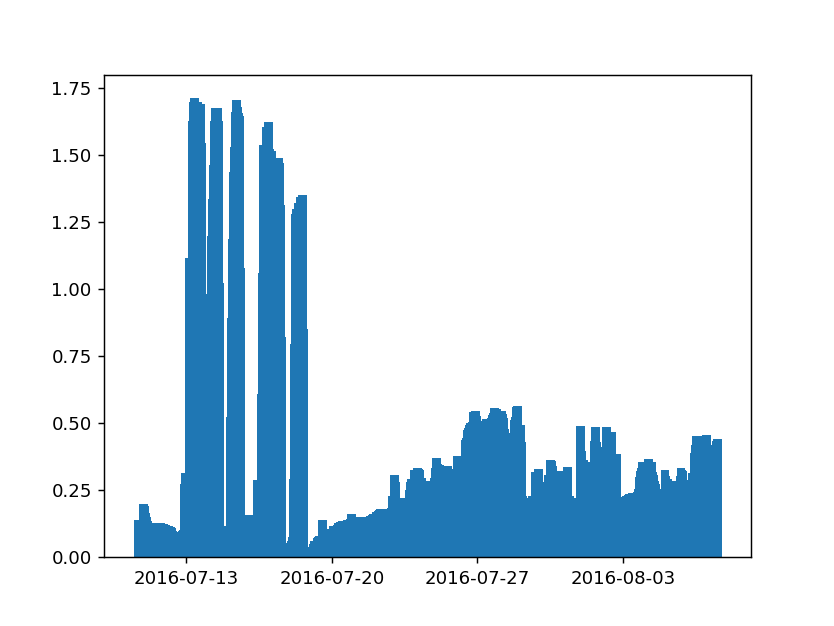

In [16]:
FillVar = 'fch4'
Site = 'Illisarvik'
if FillVar == 'fco2':
    Vars = ['PPFD_Avg','wind_speed','Out_of_Basin','Temp','VWC','AirTC_Avg']
#     Var = 'PPFD_Avg
    Var = {'Variable':'PPFD_Avg','pct':.5,'Value':0}
    dx = 'AirTC_Avg'
    N = 140
else:
    Vars = ['wind_speed','air_pressure','AirTC_Avg','Temp','VWC','Sedge','Grass','Sparse','Out_of_Basin']
    Vars = ['Sedge','VWC']
#     Var = 'VWC'
    Var = {'Variable':'Sedge','Value':1,'pct':None}
    dx = 'VWC'
    N=181
if __name__=='__main__':
    RST,params = SaveRun(FillVar,Vars,N,Scope='Test')
# RST,params = SaveRun(FillVar,Vars,N,Var_Loss=True)#,Scope='Test')



In [12]:

def Fix(RST,params,Vars,d,Fixed_Vals,fixall=True,n=50):
    di = [i for i,x in enumerate(Vars) if x in d]
    RST.Scale(params['Y'],Vars)
    y = RST.y*1.0
    X = RST.X*1.0
    Fixers = RST.XScaled.transform([Fixed_Vals])
    if fixall == True:
        dx = X[:,di]
        X[:,:]=Fixers
        X[:,di]=dx
        Xnu = np.zeros((n,X.shape[1]))
        dx = np.linspace(X[:,di].min(),X[:,di].max(),n)[:,np.newaxis]
        Xnu[:,:]=Fixers
        Xnu[:,di]=dx
    else:
        Xnu = RST.X_fill*1.0
        Xnu[:,di]=Fixers[:,di]
    return(Xnu,RST)

def Deriv(RST,Var,n=50):
    X = np.linspace(RST.Master[Var].min(),RST.Master[Var].max(),n)
    dx = np.diff(X)
    X = RST.XScaled.transform(X.reshape(-1,1))
    return(X,dx)    

def PCT(RST,Vars,dx,Var,Runs,params,ax,color):
    Fixed_Vals = RST.Master[Vars].mean()
    if Var['pct']==None:
        Fixed_Vals[Var['Variable']] = Var['Value']
        Var['Value'] = np.round(Var['Value'],2)
    else:
        Var['Value'] = RST.Master[Var['Variable']].quantile(Var['pct'])
        Fixed_Vals[Var['Variable']] = Var['Value']
        Var['Value'] = np.round(Var['Value'],2)
    X,RST=Fix(RST,params,Vars,dx,Fixed_Vals.values)
    ax,yMean,pred_int=MF.Map(X,dx,params,ax,color=color,label=Var['Variable']+' '+str(Var['Value']),RST=RST)
    print('Mean: ',yMean,' +/-: ',pred_int)
    return(ax)
    
def Specifix(RST,Vars,Runs,params,ax,color,fractions):
    Fixed_Vals = RST.Master[Vars].mean()
    Fixers=[]
    for key, value in fractions.items():
        if key in Vars:
            Fixed_Vals[key]=value
            Fixers.append(key)
    X,RST=Fix(RST,params,Vars,Fixers,Fixed_Vals.values,fixall=False)
    ax,yMean,pred_int=MF.Map(X,Fixers,params,ax,color=color,label='Upscaled',RST=RST,Derivs=False)
    print('Mean: ',yMean,' +/-: ',pred_int)
    return(ax)


In [13]:

# fig,ax = plt.subplots(2,1,figsize = (7.5,10))
# cb = ax[0].scatter(RST.Master[dx],RST.Master[params['Y']],c=RST.Master[Var['Variable']],cmap = 'bwr')
# PCT(RST,Vars,dx,Var,Runs,params,ax,'red')
# # # Var = {'Variable':'VWC','Value':.6,'pct':None}
# # # PCT(RST,Vars,dx,Var,Runs,params,ax,'black')
# Var['pct']=1
# PCT(RST,Vars,dx,Var,Runs,params,ax,'blue')


# fractions = {'Sedge':0.12514268577673673,'Grass':0.15870928105098725,
#              'Out_of_Basin':0.1,'Sparse':0.08514438609236921,'Shrub':0.599524619614659}
# fractions = {'Sedge':1,'Grass':0,'Out_of_Basin':0,'Sparse':0,'Shrub':0}
# fractions={}

# Temp = RST.Master.reset_index(drop=True)
# fig,ax = plt.subplots(1,1,figsize = (7.5,5))
# ax.plot(Temp.index,Temp[params['Y']])
# # print(Temp[params['Y']].mean())
# Specifix(RST,Vars,Runs,params,ax,'green',fractions)
# print(RST.Master[['AirTC_Avg','Temp']].mean())




# Fixed_Vals = RST.Master[Vars].mean()
# pct = .5
# Fixed_Vals[Var]=RST.Master[Var].quantile(pct)
# X,RST=Fix(RST,params,Vars,dx,Fixed_Vals.values)
# ax,yMax=Map_Multiple(X,dx,params,Runs,ax,color='black',label=Var+' '+str(pct)+'th Pct',RST=RST)

# Fixed_Vals = RST.Master[Vars].mean()
# pct = 0
# Fixed_Vals[Var]=RST.Master[Var].quantile(pct)
# X,RST=Fix(RST,params,Vars,dx,Fixed_Vals.values)
# ax,yMax=Map_Multiple(X,dx,params,Runs,ax,color='blue',label=Var+' '+str(pct)+'th Pct',RST=RST)

# print(yMax,Runs['RMSE'].mean()**.5/(params['K']**.5)*stats.t.ppf(1-0.025,params['K']))
# ax[0].grid()

# ax[0].set_label(params['Y'])
# ax[1].set_xlabel(dx)
# ax[1].set_ylabel('d'+params['Y']+'/d'+dx)
# ax[1].grid()
# ax[0].legend()
# ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.tight_layout()
# plt.savefig('Figure3.png',dpi=300)

In [14]:
# PI
